Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/justinshih/opt/anaconda3/envs/new_env/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/justinshih/opt/anaconda3/envs/new_env/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/justinshih/opt/anaconda3/envs/new_env/lib/python3.8/site-packages/keyboard/__init__.py", line 294, in listen
    _os_keyboard.listen(self.direct_callback)
  File "/Users/justinshih/opt/anaconda3/envs/new_env/lib/python3.8/site-packages/keyboard/_darwinkeyboard.py", line 430, in listen
    raise OSError("Error 13 - Must be run as administrator")
OSError: Error 13 - Must be run as administrator


['CASIO USB-MIDI']
開始捕捉 MIDI 訊息，按 'Esc' 結束錄音。


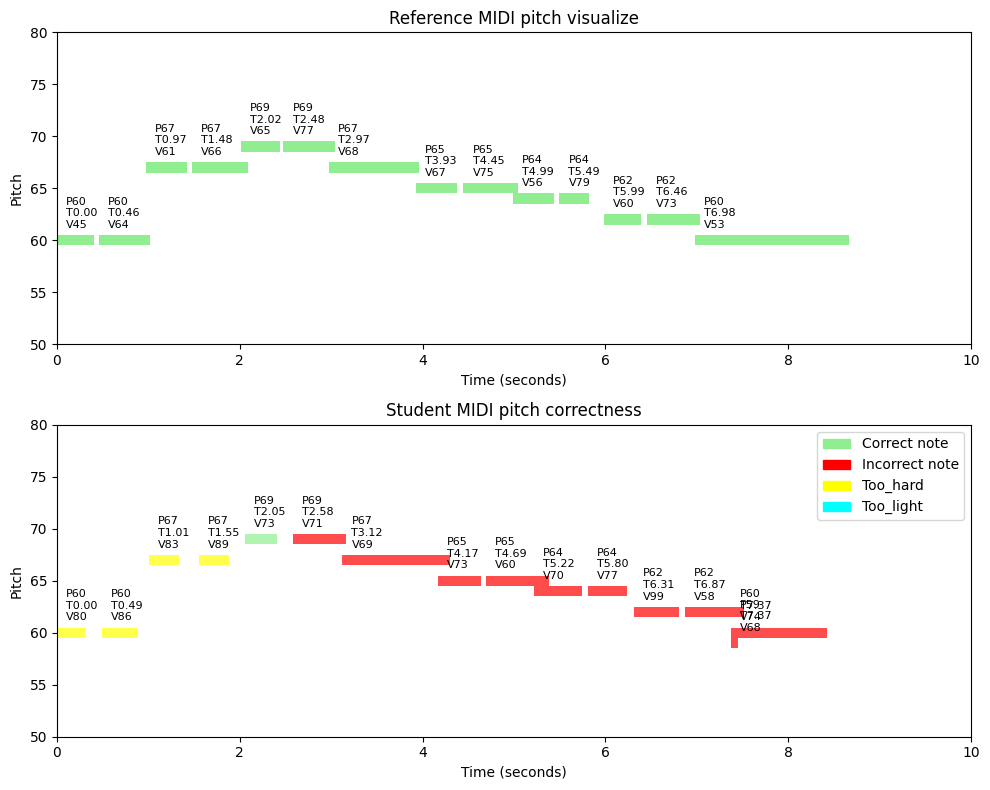

In [1]:
import mido
import time
import keyboard
import pretty_midi
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

print(mido.get_input_names())
port_name = mido.get_input_names()[0]

# 設定 BPM 和每拍的 ticks 數
BPM = 96
ticks_per_beat = 480

# 計算每秒的 ticks 數
ticks_per_second = (ticks_per_beat * BPM) / 60

# 加載範本 MIDI 並提取範本音符，進行修剪靜音
def load_reference_midi(reference_path):
    ref_midi = pretty_midi.PrettyMIDI(reference_path)
    ref_notes = [(note.pitch, note.start, note.end, note.velocity) for instrument in ref_midi.instruments for note in instrument.notes]
    ref_notes = trim_silence(ref_notes)
    return ref_notes

# 修剪靜音部分
def trim_silence(ref_notes):
    if not ref_notes:
        return ref_notes
    first_note_time = min(note[1] for note in ref_notes)
    trimmed_notes = [(pitch, start - first_note_time, end - first_note_time, velocity) for pitch, start, end, velocity in ref_notes]
    return trimmed_notes

# 初始化實時視覺化
def init_visualization(reference_path):
    ref_notes = load_reference_midi(reference_path)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # 繪製範本音符
    for pitch, start, end, velocity in ref_notes:
        ax1.barh(pitch, end - start, left=start, height=1, color='lightgreen')
        ax1.text(start + 0.1, pitch + 1, f'P{pitch}\nT{start:.2f}\nV{velocity}', va='bottom', fontsize=8, ha='left')

    ax1.set_title("Reference MIDI pitch visualize")
    ax1.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Pitch")
    ax1.set_xlim(0, 10)
    ax1.set_ylim(50, 80)

    ax2.set_title("Student MIDI pitch correctness")
    ax2.set_xlabel("Time (seconds)")
    ax2.set_ylabel("Pitch")
    ax2.set_xlim(0, 10)
    ax2.set_ylim(50, 80)

    # 添加圖例
    correct_patch = mpatches.Patch(color='lightgreen', label='Correct note')
    extra_patch = mpatches.Patch(color='red', label='Incorrect note')
    velocity_off_patch = mpatches.Patch(color='yellow', label='Velocity off')
    ref_note_start_patch = mlines.Line2D([], [], color='black', linestyle='--', label='Reference note start')
    tolerance_label = mlines.Line2D([], [], linestyle='', label=f'tolerance: 0.1(sec)')

    ax2.legend(handles=[correct_patch, extra_patch, velocity_off_patch, ref_note_start_patch, tolerance_label], loc='upper right')
    
    plt.tight_layout()
    plt.draw()
    
    return fig, ax1, ax2

def update_visualization(ax2, note_list):
    ax2.clear()
    ax2.set_title("Student MIDI pitch correctness")
    ax2.set_xlabel("Time (seconds)")
    ax2.set_ylabel("Pitch")
    ax2.set_xlim(0, 10)
    ax2.set_ylim(50, 80)

    for note in note_list:
        pitch, start_time, end_time, correct, color, velocity = note
        duration = end_time - start_time
        ax2.barh(pitch, duration, left=start_time, height=1, color=color, alpha=0.7)
        ax2.text(start_time + 0.1, pitch + 1, f'P{pitch}\nT{start_time:.2f}\nV{velocity}', va='bottom', fontsize=8, ha='left')

    # 添加圖例
    correct_patch = mpatches.Patch(color='lightgreen', label='Correct note')
    extra_patch = mpatches.Patch(color='red', label='Incorrect note')
    Too_hard= mpatches.Patch(color='yellow', label='Too_hard')
    Too_light = mpatches.Patch(color='cyan', label='Too_light')
    
    ax2.legend(handles=[correct_patch, extra_patch, Too_hard, Too_light], loc='upper right')
    
    ax2.figure.canvas.flush_events()

# 調整compare_and_visualize來處理velocity
def compare_and_visualize(ref_notes, student_note, ax2, note_list, tolerance=0.1, velocity_tolerance=20):
    pitch, start_time, end_time, velocity = student_note
    closest_ref_note = None
    closest_time_diff = float('inf')

    # 比對音高、時間和力度
    for ref_pitch, ref_start, ref_end, ref_velocity in ref_notes:
        if ref_pitch == pitch:
            time_diff = abs(start_time - ref_start)
            if time_diff < closest_time_diff and time_diff <= tolerance:
                closest_time_diff = time_diff
                closest_ref_note = (ref_pitch, ref_start, ref_end, ref_velocity)

    if closest_ref_note:
        ref_pitch, ref_start, ref_end, ref_velocity = closest_ref_note

        if abs(ref_velocity - velocity) <= velocity_tolerance:
            color = 'lightgreen'  # 力度差異在容差範圍內
        elif ref_velocity - velocity < -velocity_tolerance:
            color = 'yellow'  # 力度差異超出容差範圍
        else:
            color = "cyan"
        new_note = (pitch, start_time, end_time, True, color, velocity)
    else:
        new_note = (pitch, start_time, end_time, False, 'red', velocity)  # 音高錯誤顯示紅色

    note_list.append(new_note)
    update_visualization(ax2, note_list)

# 捕捉MIDI輸入，並處理velocity
def start_real_time_midi_capture(reference_path):
    ref_notes = load_reference_midi(reference_path)
    
    midi_file = mido.MidiFile()
    midi_track = mido.MidiTrack()
    midi_file.tracks.append(midi_track)

    print("開始捕捉 MIDI 訊息，按 'Esc' 結束錄音。")
    start_time = time.perf_counter()
    last_time = start_time
    student_notes = {}
    note_list = []

    duration = 10
    start_flag = False

    fig, ax1, ax2 = init_visualization(reference_path)

    with mido.open_input(port_name) as midi_in:

        def handle_midi(message):
            nonlocal last_time
            current_time = time.perf_counter()
            elapsed_time = current_time - last_time
            ticks = int(elapsed_time * ticks_per_second)

            if message.type == 'note_on' and message.velocity > 0:
                note_start_time = current_time - start_time
                student_notes[message.note] = (note_start_time, message.velocity)

            elif message.type == 'note_off' or (message.type == 'note_on' and message.velocity == 0):
                note_end_time = current_time - start_time
                if message.note in student_notes:
                    note_start_time, velocity = student_notes.pop(message.note)
                    student_note = (message.note, note_start_time, note_end_time, velocity)
                    compare_and_visualize(ref_notes, student_note, ax2, note_list)

            last_time = current_time

        try:
            while time.perf_counter() - start_time < duration:
                for message in midi_in.iter_pending():
                    start_flag = True
                    handle_midi(message)
                time.sleep(0.01)
                if keyboard.is_pressed('esc'):
                    print("偵測到 Esc，結束錄音。")
                    break
                if not start_flag:
                    start_time = time.perf_counter()
                    last_time = start_time

        except KeyboardInterrupt:
            print("結束錄音。")


# 使用方法
reference_midi_path = '0_t2.mid'
start_real_time_midi_capture(reference_midi_path)

plt.show()
